# Newell-Lee Evaporator 

Solve the following IVP to simulate the Evaporator example from Pilario et al. (2021) in $t\in[0, 20]$ min:

$$ \frac{dL_2}{dt} = \frac{F_1-F_4-F_2}{20}$$

$$ \frac{dX_2}{dt} = \frac{F_1 X_1 - F_2 X_2}{20} $$

$$ \frac{dP_2}{dt} = \frac{F_4 - F_5}{4} $$

Apply piecewise step changes on F200, P100, and F2 inputs every 2 min.

In [5]:
from scipy.integrate import solve_ivp
from pyomo.environ import *
from pyomo.dae import DerivativeVar, ContinuousSet
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
evap = ConcreteModel()

evap.tf = Param(initialize=20)
evap.t = ContinuousSet(bounds=(0,evap.tf))

# States
evap.L2 = Var(evap.t, initialize=1, bounds=(0, 4))
evap.P2 = Var(evap.t, initialize=50.5)
evap.X2 = Var(evap.t, initialize=25)

# Inputs and Disturbances
evap.T200 = Param(evap.t, default=25)
evap.F1 = Param(evap.t, default=10)
evap.F3 = Param(evap.t, default=50)
evap.X1 = Param(evap.t, default=5)
evap.T1 = Param(evap.t, default=40)

evap.F200 = Param(evap.t, mutable=True)  # Input to be manipulated
evap.P100 = Param(evap.t, mutable=True)  # Input to be manipulated
evap.F2 = Param(evap.t, mutable=True)    # Input to be manipulated

# Other outputs
evap.F4 = Var(evap.t, initialize=8)
evap.F5 = Var(evap.t, initialize=8)
evap.T2 = Var(evap.t, initialize=84.6)
evap.T3 = Var(evap.t, initialize=80.6)
evap.F100 = Var(evap.t, initialize=9.27)
evap.T100 = Var(evap.t, initialize=119.9)
evap.Q100 = Var(evap.t, initialize=339.2)
evap.T201 = Var(evap.t, initialize=46.15)
evap.Q200 = Var(evap.t, initialize=308)

# Setup derivative vars for states
evap.dL2dt = DerivativeVar(evap.L2, initialize=0)
evap.dP2dt = DerivativeVar(evap.P2, initialize=0)
evap.dX2dt = DerivativeVar(evap.X2, initialize=0)

# Set an objective
evap.obj = Objective(expr=1)

evap.z1dot = Constraint(evap.t, rule = lambda m, i: \
                       m.dL2dt[i]*20 == m.F1[i] - m.F4[i] - m.F2[i])
evap.z2dot = Constraint(evap.t, rule = lambda m, i: \
                       m.dX2dt[i]*20 == m.F1[i]*m.X1[i] - m.F2[i]*m.X2[i])
evap.z3dot = Constraint(evap.t, rule = lambda m, i: \
                       m.dP2dt[i]*4 == m.F4[i] - m.F5[i])

# Other constraints
evap.con1 = Constraint(evap.t, rule = lambda m, i: \
                      m.T2[i] == 0.5616*m.P2[i] + 0.3126*m.X2[i] + 48.43)
evap.con2 = Constraint(evap.t, rule = lambda m, i: \
                      m.T3[i] == 0.507*m.P2[i] + 55)
evap.con3 = Constraint(evap.t, rule = lambda m, i: \
                      m.F4[i]*38.5 == m.Q100[i] - 0.07*m.F1[i]*(m.T2[i] - m.T1[i]))
evap.con4 = Constraint(evap.t, rule = lambda m, i: \
                      m.T100[i] == 0.1538*m.P100[i] + 90)
evap.con5 = Constraint(evap.t, rule = lambda m, i: \
                      m.Q100[i] == 0.16*(m.F1[i] + m.F3[i])*(m.T100[i] - m.T2[i]))
evap.con6 = Constraint(evap.t, rule = lambda m, i: \
                      m.F100[i]*36.6 == m.Q100[i])
evap.con7 = Constraint(evap.t, rule = lambda m, i: \
                      m.Q200[i]*(0.14*m.F200[i]+6.84) == 0.9576*m.F200[i]*(m.T3[i]-m.T200[i]))
evap.con8 = Constraint(evap.t, rule = lambda m, i:\
                      m.T201[i] == m.T200[i] + m.Q200[i]/0.07/m.F200[i])
evap.con9 = Constraint(evap.t, rule = lambda m, i: \
                      m.F5[i]*38.5 == m.Q200[i])

def _init(m):
    yield m.L2[0] == 1.0
    yield m.P2[0] == 50.5
    yield m.X2[0] == 25
evap.initcon = ConstraintList(rule=_init)

# Discretize using collocation
discretizer = TransformationFactory('dae.collocation')
discretizer.apply_to(evap, nfe=20, ncp=3, scheme='LAGRANGE-RADAU')

# Step change data
timepoints = list(evap.t)
np.random.seed(0)
i_data = np.arange(0, 20, 2)
F200data = (np.random.rand(i_data.shape[0])-0.5)*50 + 208
P100data = (np.random.rand(i_data.shape[0])-0.5)*50 + 194.7
F2data = (np.random.rand(i_data.shape[0])-0.5)*2 + 2
F200data[0] = 208
P100data[0] = 194.7
F2data[0] = 2
for i, t in enumerate(timepoints):
    pos = np.argwhere(t>=i_data)[-1]
    evap.F200[t] = F200data[pos][0]
    evap.P100[t] = P100data[pos][0]
    evap.F2[t] = F2data[pos][0]
    
# Solve using Pyomo IPOPT
solver = SolverFactory('cyipopt')
solver.solve(evap, tee=True)

Please recompile / update your pynumero_ASL library.

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2550
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      915
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       61
                     variables w

{'Problem': [{'Name': 'unknown', 'Lower bound': -inf, 'Upper bound': 1.0, 'Number of objectives': 1, 'Number of constraints': 915, 'Number of variables': 915, 'Number of binary variables': 0, 'Number of integer variables': 0, 'Number of continuous variables': 915, 'Sense': 'minimize'}], 'Solver': [{'Name': 'cyipopt', 'Status': 'ok', 'Return code': 0, 'Message': b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).', 'Wallclock time': 0.04961789999999988, 'Termination condition': 'optimal'}]}

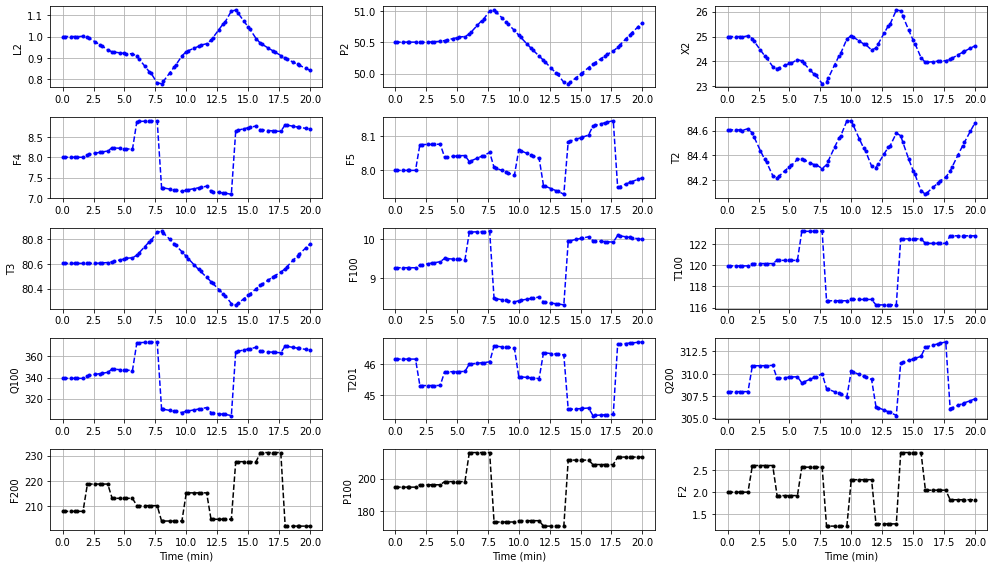

In [3]:
model_vars = evap.component_map(ctype=Var)
model_params = evap.component_map(ctype=Param)

plt.figure(figsize=(14, 8))
s_list = []
col_list = []
ctr = 1
for k in model_vars.keys():
    v = model_vars[k]
    if v.name[0] != 'd':
        s = pd.Series(v.extract_values(), index=v.extract_values().keys())
        s.sort_index(inplace=True)
        s_list.append(s)
        col_list.append(v.name)
        plt.subplot(5, 3, ctr)
        plt.plot(s.index, s, 'b.--')
        plt.ticklabel_format(useOffset=False, style='plain')
        plt.ylabel(v.name)
        plt.grid()
        ctr += 1

for k in model_params.keys():
    v = model_params[k]
    if v.name == 'F200' or v.name == 'P100' or v.name == 'F2':
        s = pd.Series(v.extract_values(), index=v.extract_values().keys())
        s.sort_index(inplace=True)
        s_list.append(s)
        col_list.append(v.name)
        plt.subplot(5, 3, ctr)
        plt.plot(s.index, s, 'k.--')
        plt.ticklabel_format(useOffset=False, style='plain')
        plt.xlabel('Time (min)')
        plt.ylabel(v.name)
        plt.grid()
        ctr += 1

evap_df = pd.concat(s_list, axis=1)
evap_df.columns = col_list
plt.tight_layout()
plt.show()

In [4]:
evap_df.head(10)

,L2,P2,X2,F4,F5,T2,T3,F100,T100,Q100,T201,Q200,F200,P100,F2
0.000000,1.000000,50.500000,25.000000,8.000803,7.999617,84.605800,80.603500,9.269262,119.944860,339.254976,46.152833,307.985251,208.000000,194.700000,2.000000
0.155051,0.999994,50.500046,25.000000,8.000796,7.999620,84.605826,80.603523,9.269255,119.944860,339.254729,46.152842,307.985379,208.000000,194.700000,2.000000
0.644949,0.999975,50.500188,25.000000,8.000775,7.999631,84.605905,80.603595,9.269234,119.944860,339.253963,46.152869,307.985778,208.000000,194.700000,2.000000
1.000000,0.999961,50.500288,25.000000,8.000760,7.999638,84.605962,80.603646,9.269219,119.944860,339.253421,46.152889,307.986061,208.000000,194.700000,2.000000
1.155051,0.999147,50.500365,24.983011,8.002169,7.999644,84.600695,80.603685,9.270601,119.944860,339.303988,46.152904,307.986277,208.000000,194.700000,2.000000
1.644949,1.001319,50.500554,25.030409,7.998177,7.999657,84.615617,80.603781,9.266687,119.944860,339.160732,46.152940,307.986807,208.000000,194.700000,2.000000
2.000000,0.996292,50.500002,24.917177,8.063135,8.075163,84.579911,80.603501,9.334335,120.167062,341.636651,45.302388,310.893779,218.759468,196.144746,2.598317
2.155051,0.991127,50.499722,24.804028,8.072640,8.075142,84.544383,80.603359,9.343653,120.167062,341.977717,45.302337,310.892985,218.759468,196.144746,2.598317
2.644949,0.974339,50.501177,24.461133,8.101098,8.075250,84.438011,80.604097,9.371554,120.167062,342.998885,45.302606,310.897111,218.759468,196.144746,2.598317
3.000000,0.961750,50.504323,24.225916,8.120297,8.075481,84.366249,80.605692,9.390377,120.167062,343.687802,45.303188,310.906029,218.759468,196.144746,2.598317
